In [1]:
from pathlib import Path
from astropy.io import fits
import pandas as pd
import numpy as np
import collections

In [2]:
from RTAscience.cfg.Config import Config

In [12]:
datapath = Path("/data01/home/baroncelli/phd/DATA")
simFolder = datapath.joinpath("obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5")
cfg = Config(simFolder.joinpath("config.yaml"))
runid = cfg.get('runid')

In [4]:
if cfg.get("simtype") == 'bkg':
    inputFitsFile = simFolder.joinpath("backgrounds","bkg000001.fits")
else:
    inputFitsFile = simFolder.joinpath(runid,"ebl000001.fits")    

In [5]:
import os 
os.environ["DATA"] = str(datapath)
from rtapipe.pyscripts.phlists_to_photometry_plot import Photometry

/data01/home/baroncelli/phd/DATA/templates/grb_afterglow/GammaCatalogV1.0/run0406_ID000126_ebl.fits
Filename: /data01/home/baroncelli/phd/DATA/obs/obs_st_bkg_tr_1_os_0_emin_0.03_emax_0.15_roi_2.5/backgrounds/bkg000001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  EVENTS        1 BinTableHDU     88   349336R x 8C   [1J, 1D, 1E, 1E, 1E, 1E, 1E, 1J]   
  2  GTI           1 BinTableHDU     20   1R x 2C   [1D, 1D]   
ColDefs(
    name = 'EVENT_ID'; format = '1J'; bscale = 1; bzero = 2147483648
    name = 'TIME'; format = '1D'; unit = 's'
    name = 'RA'; format = '1E'; unit = 'deg'
    name = 'DEC'; format = '1E'; unit = 'deg'
    name = 'ENERGY'; format = '1E'; unit = 'TeV'
    name = 'DETX'; format = '1E'; unit = 'deg'
    name = 'DETY'; format = '1E'; unit = 'deg'
    name = 'MC_ID'; format = '1J'
)


In [13]:
p = Photometry()
args = {
    'obs_dir': str(simFolder),
    'region_radius': 0.5,
    'mode': 'windowed',
    'window_size': 25,
    'window_step': 25,
    'plot' : 1,
    'override': 1,
    'countcheck': 0,
    'showplot' : 1
}


Region center  {'ra': 33.057, 'dec': -51.841} with radius 0.5 deg
Produced:  /data01/home/baroncelli/phd/DATA/obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5/run0406_ID000126/ap/ebl000001_ap_mode_windowed_wsize_25_wstep_25_rad_0.5.csv


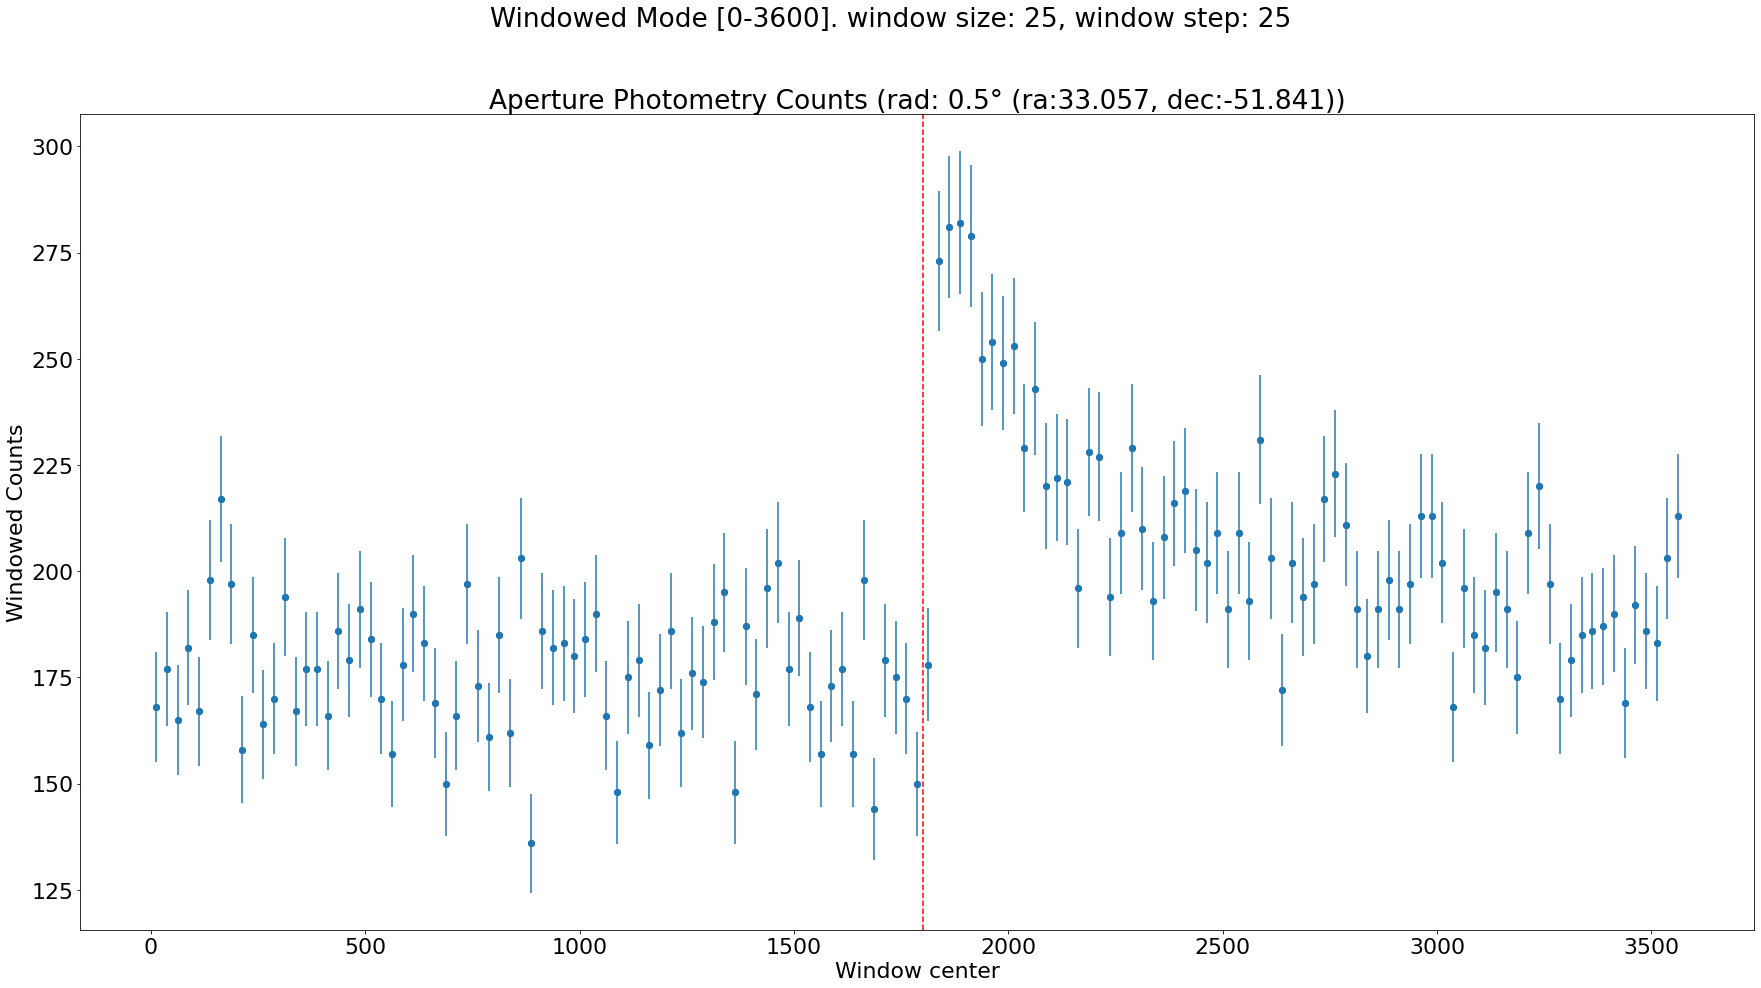

Produced:  /data01/home/baroncelli/phd/DATA/obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5/run0406_ID000126/ap/ebl000001_ap_mode_windowed_wsize_25_wstep_25_rad_0.5.png


In [14]:
p.main(collections.namedtuple("args", args.keys())(*args.values()))


Region center  {'ra': 33.057, 'dec': -51.841} with radius 0.5 deg
Produced:  /data01/home/baroncelli/phd/DATA/obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5/run0406_ID000126/ap/ebl000001_ap_mode_windowed_wsize_5_wstep_5_rad_0.5.csv


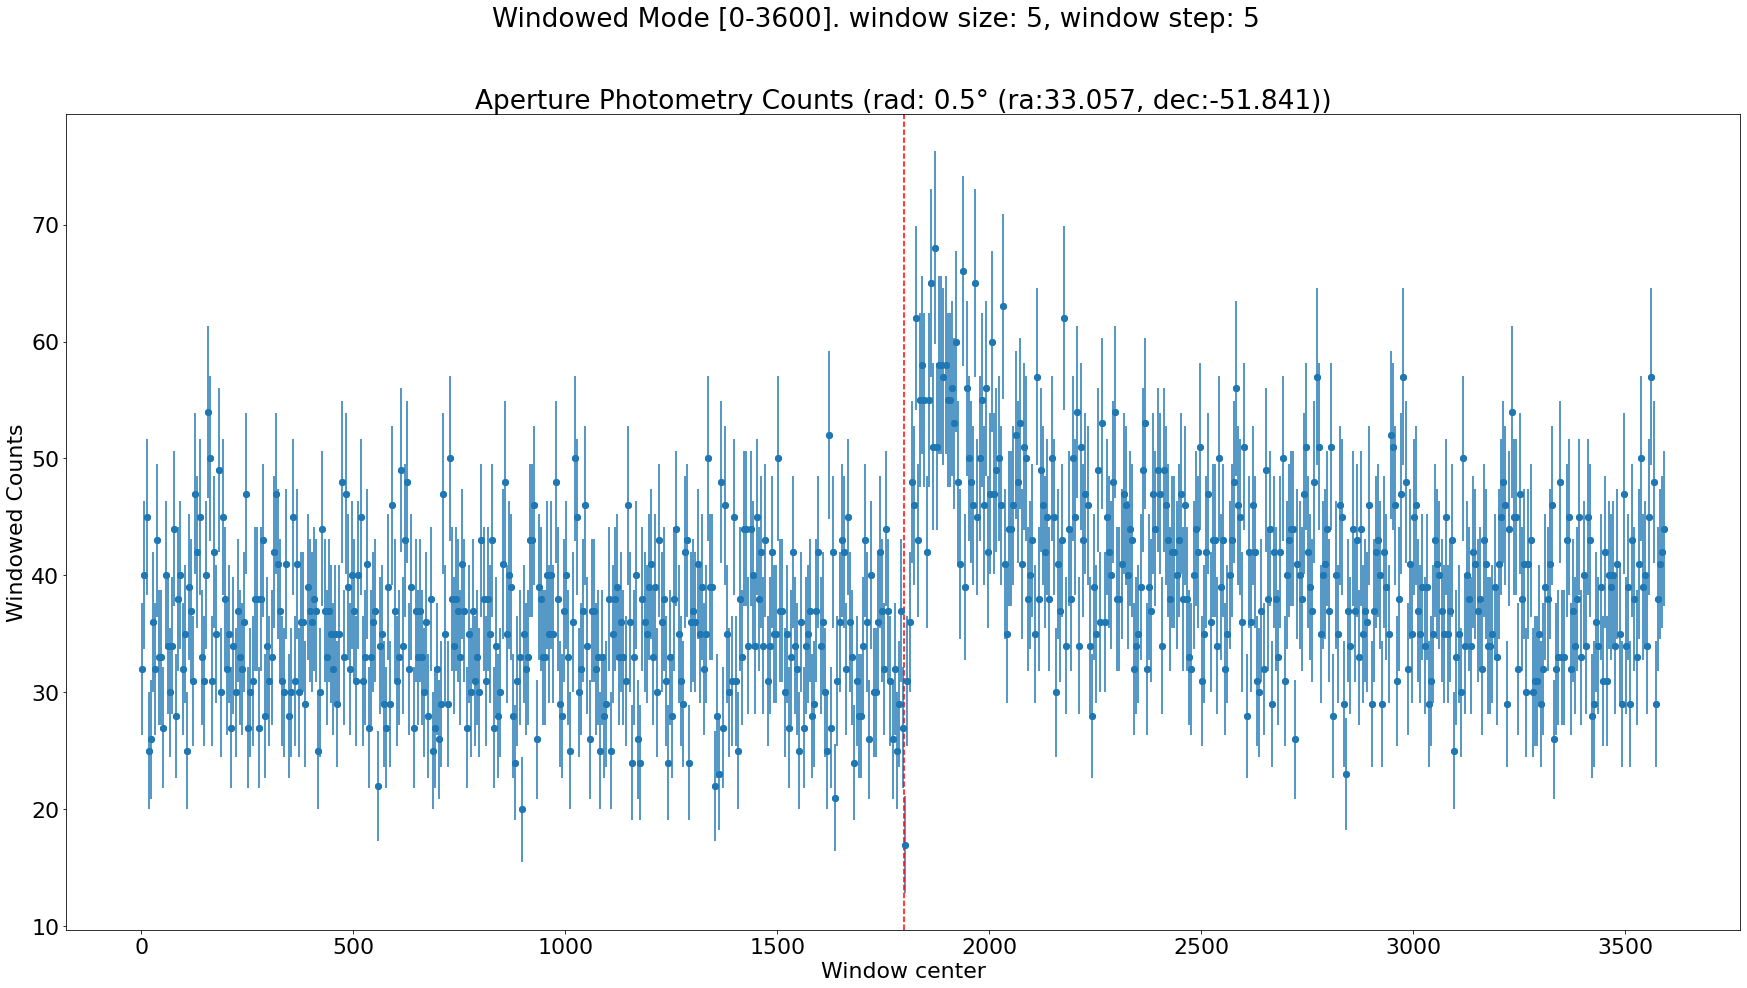

Produced:  /data01/home/baroncelli/phd/DATA/obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5/run0406_ID000126/ap/ebl000001_ap_mode_windowed_wsize_5_wstep_5_rad_0.5.png


In [15]:
args['window_size'] = 5
args['window_step'] = 5
p.main(collections.namedtuple("args", args.keys())(*args.values()))